In [1]:
!pip install qiskit qiskit-aer
!pip install matplotlib
!pip install pylatexenc

Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Qiskit prototype for a small QMPC interaction (simulation)
# Requires: qiskit, qiskit-aer
# Run in an environment with qiskit and qiskit-aer installed.

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np
import random

# ---------- Helpers: QOTP ----------
def apply_qotp(qc, q_index, key):
    """Apply QOTP X^a Z^b to qubit q_index using key=(a,b)."""
    a, b = key
    if a == 1:
        qc.x(q_index)
    if b == 1:
        qc.z(q_index)

def undo_qotp(qc, q_index, key):
    """Undo QOTP (apply Z^b X^a)."""
    a, b = key
    if b == 1:
        qc.z(q_index)
    if a == 1:
        qc.x(q_index)

# ---------- Gate teleportation gadget for Rz(theta) using a magic-like state ----------
# We'll implement a simple teleportation gadget for a single-qubit gate using a prepared ancilla.
# This is pedagogical rather than an optimal T-gadget.

def teleport_apply_Rz(qc, data_q, anc_q, meas_c0, meas_c1, theta):
    """
    Perform Bell-measurement between data_q and anc_q, then conditionally apply Rz(theta) on ancilla result.
    We simulate measurement and classical correction externally (like Pi_CL would do).
    """
    # Create Bell basis measurement (data and ancilla)
    qc.cx(data_q, anc_q)
    qc.h(data_q)
    qc.measure(data_q, meas_c0)
    qc.measure(anc_q, meas_c1)
    # Classical correction will be applied later by the driver code (in simulator)


# ---------- Simulated Pi_CL: classical aggregator ----------
def pi_cl_aggregate_and_compute_corrections(meas0, meas1, qotp_keys):
    """
    Simulated classical MPC aggregator.
    Inputs: measurement results meas0, meas1 (0/1 ints), qotp_keys: dict of keys per party.
    Output: correction bits to apply to the target qubit (a tuple (apply_X, apply_Z)).
    For the toy gadget, we use a simple rule:
      - apply X if meas1 == 1
      - apply Z if meas0 == 1
    Additionally, if QOTP is used, we instruct the decryptor to invert QOTP keys.
    """
    apply_X = (meas1 == 1)
    apply_Z = (meas0 == 1)
    # For QOTP we assume keys are shared and reconstructed here (simulated)
    return apply_X, apply_Z

# ---------- Main demonstration: two-party, one-qubit each ----------
def run_protocol_demo(theta=np.pi/4):
    # Setup
    simulator = AerSimulator()
    qr = QuantumRegister(3, 'q')      # q0: party A data; q1: ancilla (teleportation); q2: party B data (target)
    cr = ClassicalRegister(2, 'm')    # classical bits for Bell measurements
    qc = QuantumCircuit(qr, cr)

    # Initial states: prepare |psi> on q0 (party A), and |0> on q2 (party B)
    # Example: |psi> = H|0> (for demonstration)
    qc.h(qr[0])

    # QOTP keys (simulated, secret-shared). We'll simulate sharing and reconstruction.
    key_A = (random.randint(0,1), random.randint(0,1))  # a_A, b_A
    key_B = (random.randint(0,1), random.randint(0,1))  # a_B, b_B

    # Party A applies QOTP to its qubit and "sends" it (we keep it local in simulator)
    apply_qotp(qc, qr[0], key_A)

    # Prepare ancilla magic-like state on q1: we'll use Rz(theta)|+> as a stand-in
    qc.h(qr[1])
    qc.rz(theta, qr[1])

    # Teleportation gadget: perform Bell-measurement between data (q0) and ancilla (q1)
    teleport_apply_Rz(qc, qr[0], qr[1], 0, 1, theta)

    # Now we need to run the circuit up to measurement and get measurement outcomes.
    qc = transpile(qc, simulator)
    job = simulator.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    # Extract the single shot measurement result (two bits)
    measured_bits = list(counts.keys())[0]  # format like 'b1b0' where b1 = cr[1], b0 = cr[0]
    meas0 = int(measured_bits[::-1][0])  # cr[0]
    meas1 = int(measured_bits[::-1][1])  # cr[1]

    # Classical aggregator (simulated Pi_CL) computes corrections
    apply_X, apply_Z = pi_cl_aggregate_and_compute_corrections(meas0, meas1, { 'A': key_A, 'B': key_B })

    # Now construct a new circuit continuing from the post-measurement state:
    # For simulation convenience, we'll re-create the target qubit (q2) and apply corrections to it.
    qc2 = QuantumCircuit(qr, name='post')
    # Start q2 in |0>, then conditionally apply corrections determined by Pi_CL
    if apply_X:
        qc2.x(qr[2])
    if apply_Z:
        qc2.z(qr[2])
    # Additionally, apply the gate Rz(theta) on q2 to reflect the teleported gate effect (approximate)
    qc2.rz(theta, qr[2])

    # Now undo QOTP on target if needed (simulate key reconstruction by Pi_CL)
    # For demonstration, assume final recipient reconstructs keys: we simply undo key_B
    undo_qotp(qc2, qr[2], key_B)

    final_qc = qc2
    # Combine circuits for execution convenience (note: in an actual distributed setting these are separate steps)
    full = qc.compose(final_qc)
    full = transpile(full, simulator)
    job2 = simulator.run(full, shots=1024)
    res2 = job2.result()
    counts2 = res2.get_counts()
    print("Final measurement counts (of full circuit):", counts2)

if __name__ == "__main__":
    run_protocol_demo()


Final measurement counts (of full circuit): {'10': 413, '00': 463, '01': 69, '11': 79}


QOTP Keys: A=(1, 0), B=(0, 0)

--- Circuit Part 1 (QOTP + Teleportation Measurement) ---
     ┌───┐   ┌───┐        ┌───┐┌─┐
q_0: ┤ H ├───┤ X ├─────■──┤ H ├┤M├
     ├───┤┌──┴───┴──┐┌─┴─┐└┬─┬┘└╥┘
q_1: ┤ H ├┤ Rz(π/4) ├┤ X ├─┤M├──╫─
     └───┘└─────────┘└───┘ └╥┘  ║ 
q_2: ───────────────────────╫───╫─
                            ║   ║ 
m: 2/═══════════════════════╩═══╩═
                            1   0 

--- Qubit State Check (q0 after H + QOTP, q1 after H) ---


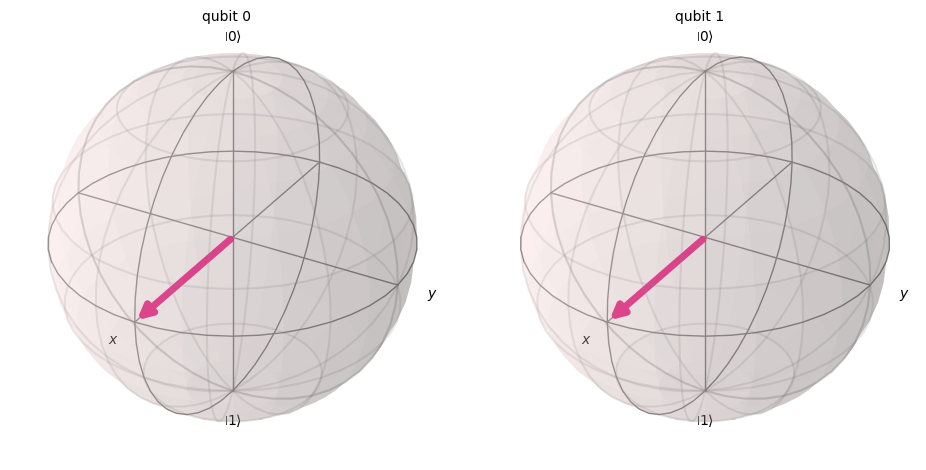


Measurement Outcome (m1m0): 10 (m0=0, m1=1)
Classical Corrections: Apply X=True, Apply Z=False

--- Full Protocol Circuit (QOTP, Teleportation, Correction, Undo QOTP) ---

--- Final Measurement Counts (Target Qubit q2) ---


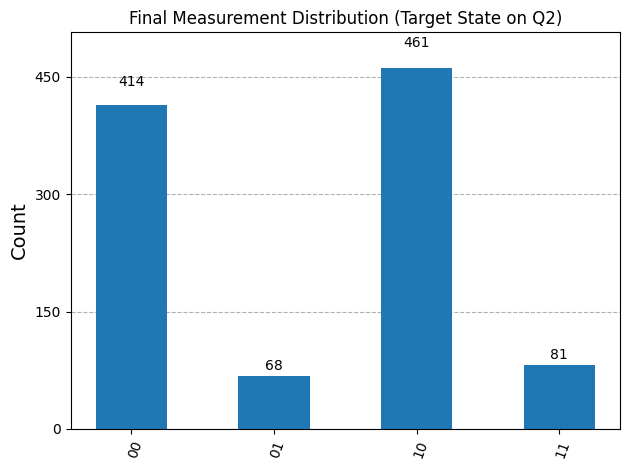

Final Qubit 2 (Target) State Counts: {'0': 482, '1': 542}


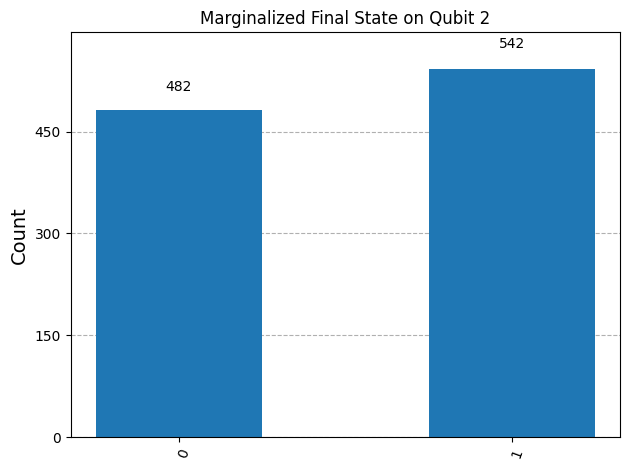

In [6]:
# Qiskit prototype for a small QMPC interaction (simulation)
# Requires: qiskit, qiskit-aer, matplotlib (for visualizations)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------- Helpers: QOTP (unchanged) ----------
def apply_qotp(qc, q_index, key):
    """Apply QOTP X^a Z^b to qubit q_index using key=(a,b)."""
    a, b = key
    if a == 1:
        qc.x(q_index)
    if b == 1:
        qc.z(q_index)

def undo_qotp(qc, q_index, key):
    """Undo QOTP (apply Z^b X^a)."""
    a, b = key
    if b == 1:
        qc.z(q_index)
    if a == 1:
        qc.x(q_index)

# ---------- Gate teleportation gadget for Rz(theta) using a magic-like state (unchanged) ----------
def teleport_apply_Rz(qc, data_q, anc_q, meas_c0, meas_c1, theta):
    """
    Perform Bell-measurement between data_q and anc_q, then conditionally apply Rz(theta) on ancilla result.
    We simulate measurement and classical correction externally (like Pi_CL would do).
    """
    # Create Bell basis measurement (data and ancilla)
    qc.cx(data_q, anc_q)
    qc.h(data_q)
    qc.measure(data_q, meas_c0)
    qc.measure(anc_q, meas_c1)

# ---------- Simulated Pi_CL: classical aggregator (unchanged) ----------
def pi_cl_aggregate_and_compute_corrections(meas0, meas1, qotp_keys):
    """
    Simulated classical MPC aggregator.
    Inputs: measurement results meas0, meas1 (0/1 ints), qotp_keys: dict of keys per party.
    Output: correction bits to apply to the target qubit (a tuple (apply_X, apply_Z)).
    For the toy gadget, we use a simple rule:
      - apply X if meas1 == 1
      - apply Z if meas0 == 1
    Additionally, if QOTP is used, we instruct the decryptor to invert QOTP keys.
    """
    apply_X = (meas1 == 1)
    apply_Z = (meas0 == 1)
    return apply_X, apply_Z

# ---------- Main demonstration: two-party, one-qubit each (with visualizations) ----------
def run_protocol_demo(theta=np.pi/4):
    # Setup
    simulator = AerSimulator()
    qr = QuantumRegister(3, 'q')      # q0: party A data; q1: ancilla (teleportation); q2: party B data (target)
    cr = ClassicalRegister(2, 'm')    # classical bits for Bell measurements
    qc = QuantumCircuit(qr, cr)

    # Initial states: prepare |psi> on q0 (party A)
    qc.h(qr[0])

    # QOTP keys
    key_A = (random.randint(0,1), random.randint(0,1))
    key_B = (random.randint(0,1), random.randint(0,1))
    print(f"QOTP Keys: A={key_A}, B={key_B}")

    # **VISUALIZATION 1: INITIAL CIRCUIT**
    # Visualize the first part of the circuit before it's run.
    qc_init = qc.copy()
    apply_qotp(qc_init, qr[0], key_A)
    qc_init.h(qr[1])
    qc_init.rz(theta, qr[1])
    teleport_apply_Rz(qc_init, qr[0], qr[1], 0, 1, theta)
    print("\n--- Circuit Part 1 (QOTP + Teleportation Measurement) ---")
    print(qc_init.draw(output='text', fold=-1)) # Use 'text' for console output
    # circuit_drawer(qc_init, output='mpl', filename='circuit_part1.png')
    # print("Saved circuit visualization to circuit_part1.png")

    # **VISUALIZATION 2: INTERMEDIATE STATE (After QOTP, Before Teleportation)**
    # Run a small sub-circuit with a 'statevector_simulator' to see the effect of QOTP.
    qc_state_check = QuantumCircuit(2)
    qc_state_check.h(0)
    apply_qotp(qc_state_check, 0, key_A)
    qc_state_check.h(1) # Ancilla prep

    initial_state = Statevector.from_instruction(qc_state_check)
    print("\n--- Qubit State Check (q0 after H + QOTP, q1 after H) ---")
    display(plot_bloch_multivector(initial_state)) # Use display() in Jupyter/IPython

    # --- Protocol Execution ---
    apply_qotp(qc, qr[0], key_A)
    qc.h(qr[1])
    qc.rz(theta, qr[1])
    teleport_apply_Rz(qc, qr[0], qr[1], 0, 1, theta)

    qc_run1 = transpile(qc, simulator)
    job = simulator.run(qc_run1, shots=1)
    result = job.result()
    counts = result.get_counts()
    measured_bits = list(counts.keys())[0]
    meas0 = int(measured_bits[::-1][0])
    meas1 = int(measured_bits[::-1][1])

    print(f"\nMeasurement Outcome (m1m0): {measured_bits} (m0={meas0}, m1={meas1})")

    # Classical aggregator computes corrections
    apply_X, apply_Z = pi_cl_aggregate_and_compute_corrections(meas0, meas1, { 'A': key_A, 'B': key_B })
    print(f"Classical Corrections: Apply X={apply_X}, Apply Z={apply_Z}")

    # Second circuit for post-measurement operations
    qc2 = QuantumCircuit(qr, name='post')
    if apply_X:
        qc2.x(qr[2])
    if apply_Z:
        qc2.z(qr[2])
    qc2.rz(theta, qr[2])
    undo_qotp(qc2, qr[2], key_B)

    # Combine circuits for visualization and execution
    full_qc = qc.compose(qc2)

    # **VISUALIZATION 3: FULL FINAL CIRCUIT**
    print("\n--- Full Protocol Circuit (QOTP, Teleportation, Correction, Undo QOTP) ---")
    full_qc.draw('mpl', style='clifford', scale=0.7, fold=-1)
    # circuit_drawer(full_qc, output='mpl', filename='circuit_full.png')
    # print("Saved full circuit visualization to circuit_full.png")

    # Run the full circuit for the final outcome distribution
    full_qc_transpiled = transpile(full_qc, simulator)
    job2 = simulator.run(full_qc_transpiled, shots=1024)
    res2 = job2.result()
    counts2 = res2.get_counts()

    # **VISUALIZATION 4: FINAL MEASUREMENT OUTCOMES**
    print("\n--- Final Measurement Counts (Target Qubit q2) ---")
    # The counts are for all three qubits: q2 q1 q0 (e.g., '000' is q2=0, q1=0, q0=0)
    # Since q0 and q1 were measured earlier, the distribution is mostly on q2.
    # To focus on q2's state, we can marginalize the counts (optional, but helpful).

    # Simple plot of all counts
    display(plot_histogram(counts2, title="Final Measurement Distribution (Target State on Q2)"))

    # Optional: Marginalize to see only q2 state (leftmost bit)
    q2_counts = {}
    for outcome, count in counts2.items():
        q2_state = outcome[0] # q2 is the leftmost bit in the string 'q2q1q0'
        q2_counts[q2_state] = q2_counts.get(q2_state, 0) + count

    print("Final Qubit 2 (Target) State Counts:", q2_counts)
    display(plot_histogram(q2_counts, title="Marginalized Final State on Qubit 2"))

    # Display the plots
    plt.show()

if __name__ == "__main__":
    # Ensure you are running this in an environment where plot_bloch_multivector
    # and plot_histogram can display output (e.g., Jupyter Notebook, or by manually saving the images).
    run_protocol_demo()

In [7]:
# Qiskit prototype for a small QMPC interaction (simulation)
# Requires: qiskit, qiskit-aer, matplotlib (for visualizations)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np
import random
import matplotlib.pyplot as plt

# Visualization parameters
VIS_PARAMS = {
    'output': 'mpl',
    'style': 'clifford',
    'scale': 0.7,
    'fold': -1
}

# ---------- Helpers: QOTP (unchanged) ----------
def apply_qotp(qc, q_index, key):
    """Apply QOTP X^a Z^b to qubit q_index using key=(a,b)."""
    a, b = key
    if a == 1:
        qc.x(q_index)
    if b == 1:
        qc.z(q_index)

def undo_qotp(qc, q_index, key):
    """Undo QOTP (apply Z^b X^a)."""
    a, b = key
    if b == 1:
        qc.z(q_index)
    if a == 1:
        qc.x(q_index)

# ---------- Gate teleportation gadget for Rz(theta) using a magic-like state (unchanged) ----------
def teleport_apply_Rz(qc, data_q, anc_q, meas_c0, meas_c1, theta):
    """
    Perform Bell-measurement between data_q and anc_q, then conditionally apply Rz(theta) on ancilla result.
    We simulate measurement and classical correction externally (like Pi_CL would do).
    """
    qc.cx(data_q, anc_q)
    qc.h(data_q)
    qc.measure(data_q, meas_c0)
    qc.measure(anc_q, meas_c1)

# ---------- Simulated Pi_CL: classical aggregator (unchanged) ----------
def pi_cl_aggregate_and_compute_corrections(meas0, meas1, qotp_keys):
    """
    Simulated classical MPC aggregator.
    Inputs: measurement results meas0, meas1 (0/1 ints), qotp_keys: dict of keys per party.
    Output: correction bits to apply to the target qubit (a tuple (apply_X, apply_Z)).
    """
    apply_X = (meas1 == 1)
    apply_Z = (meas0 == 1)
    return apply_X, apply_Z

# ---------- Main demonstration: two-party, one-qubit each (with visualizations) ----------
def run_protocol_demo(theta=np.pi/4):
    # Setup
    simulator = AerSimulator()
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(2, 'm')
    qc = QuantumCircuit(qr, cr)

    # Initial states: prepare |psi> on q0 (party A)
    qc.h(qr[0])

    # QOTP keys
    key_A = (random.randint(0,1), random.randint(0,1))
    key_B = (random.randint(0,1), random.randint(0,1))
    print(f"QOTP Keys: A={key_A}, B={key_B}")

    # **VISUALIZATION 1: INITIAL CIRCUIT (QOTP + Teleportation Measurement)**
    qc_init = qc.copy()
    apply_qotp(qc_init, qr[0], key_A)
    qc_init.h(qr[1])
    qc_init.rz(theta, qr[1])
    teleport_apply_Rz(qc_init, qr[0], qr[1], 0, 1, theta)

    circuit_drawer(qc_init, **VIS_PARAMS, filename='circuit_part1.png')
    print("\n--- Saved circuit visualization to circuit_part1.png ---")

    # **VISUALIZATION 2: INTERMEDIATE STATE (After QOTP, Before Teleportation)**
    qc_state_check = QuantumCircuit(2)
    qc_state_check.h(0)
    apply_qotp(qc_state_check, 0, key_A)
    qc_state_check.h(1)

    initial_state = Statevector.from_instruction(qc_state_check)
    print("\n--- Saved Bloch sphere visualization to state_check.png ---")
    bloch_fig = plot_bloch_multivector(initial_state)
    bloch_fig.savefig('state_check.png')
    plt.close(bloch_fig) # Close figure to free up memory

    # --- Protocol Execution ---
    apply_qotp(qc, qr[0], key_A)
    qc.h(qr[1])
    qc.rz(theta, qr[1])
    teleport_apply_Rz(qc, qr[0], qr[1], 0, 1, theta)

    qc_run1 = transpile(qc, simulator)
    job = simulator.run(qc_run1, shots=1)
    result = job.result()
    counts = result.get_counts()
    measured_bits = list(counts.keys())[0]
    meas0 = int(measured_bits[::-1][0])
    meas1 = int(measured_bits[::-1][1])

    print(f"\nMeasurement Outcome (m1m0): {measured_bits} (m0={meas0}, m1={meas1})")

    # Classical aggregator computes corrections
    apply_X, apply_Z = pi_cl_aggregate_and_compute_corrections(meas0, meas1, { 'A': key_A, 'B': key_B })
    print(f"Classical Corrections: Apply X={apply_X}, Apply Z={apply_Z}")

    # Second circuit for post-measurement operations
    qc2 = QuantumCircuit(qr, name='post')
    if apply_X:
        qc2.x(qr[2])
    if apply_Z:
        qc2.z(qr[2])
    qc2.rz(theta, qr[2])
    undo_qotp(qc2, qr[2], key_B)

    # Combine circuits for visualization and execution
    full_qc = qc.compose(qc2)

    # **VISUALIZATION 3: FULL FINAL CIRCUIT**
    circuit_drawer(full_qc, **VIS_PARAMS, filename='circuit_full.png')
    print("--- Saved full circuit visualization to circuit_full.png ---")

    # Run the full circuit for the final outcome distribution
    full_qc_transpiled = transpile(full_qc, simulator)
    job2 = simulator.run(full_qc_transpiled, shots=1024)
    res2 = job2.result()
    counts2 = res2.get_counts()

    # **VISUALIZATION 4: FINAL MEASUREMENT OUTCOMES**
    print("\n--- Saved histogram visualization to final_histogram.png and target_histogram.png ---")

    # Simple plot of all counts
    hist_fig_full = plot_histogram(counts2, title="Final Measurement Distribution (Target State on Q2)")
    hist_fig_full.savefig('final_histogram.png')

    # Optional: Marginalize to see only q2 state (leftmost bit)
    q2_counts = {}
    for outcome, count in counts2.items():
        q2_state = outcome[0] # q2 is the leftmost bit in the string 'q2q1q0'
        q2_counts[q2_state] = q2_counts.get(q2_state, 0) + count

    hist_fig_target = plot_histogram(q2_counts, title="Marginalized Final State on Qubit 2")
    hist_fig_target.savefig('target_histogram.png')

    # Close figures
    plt.close(hist_fig_full)
    plt.close(hist_fig_target)

    # Final console output
    print(f"Final Qubit 2 (Target) State Counts: {q2_counts}")

if __name__ == "__main__":
    run_protocol_demo()

QOTP Keys: A=(1, 1), B=(0, 0)

--- Saved circuit visualization to circuit_part1.png ---

--- Saved Bloch sphere visualization to state_check.png ---

Measurement Outcome (m1m0): 11 (m0=1, m1=1)
Classical Corrections: Apply X=True, Apply Z=True
--- Saved full circuit visualization to circuit_full.png ---

--- Saved histogram visualization to final_histogram.png and target_histogram.png ---
Final Qubit 2 (Target) State Counts: {'1': 514, '0': 510}
